# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                        #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.07
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             100
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
test_loss_l1=[]
test_acc_l1=[]
test_loss_l2=[]
test_acc_l2=[]
test_loss_both=[]
test_acc_both=[]
test_loss_none=[]
test_acc_none=[]

In [0]:
import copy


In [0]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

misclassified=[]
lambda1 = 0.0002
lambda2 = 0.0001
def train(model, device, train_loader, optimizer, epoch, reg):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #loss += lambda1*torch.norm(model.parameters(),1)
    #model_params = torch.cat([x.view(-1) for x in model.parameters()])
    #loss += lambda1*torch.norm(model_params,1)
    # regularization_loss = 0
    # for param in model.parameters():
    #   regularization_loss += torch.sum(torch.abs(param))
    # loss += lambda1*regularization_loss
    regularization_loss1 = 0
    regularization_loss2 = 0

    # for param in model.parameters():
    #   regularization_loss1 += torch.norm(param,1)
    #   regularization_loss2 += torch.norm(param,2)
    # loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
    if reg=="None":
      train_losses.append(loss)
    elif reg=="L1":
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
      #regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1)
      train_losses.append(loss)
    elif reg=="L2":
      for param in model.parameters():
        #regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda2*regularization_loss2)
      train_losses.append(loss)
    else:
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_losses.append(loss)




    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, reg):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            temp = pred.eq(target.view_as(pred)).sum().item()
            temp1 = target.view_as(pred)
            if(len(misclassified)<25):
              for i in range(len(temp1)):
                if(temp1[i]!=pred[i]):
                  misclassified.append([data[i],temp1[i],pred[i]])
                if(len(misclassified)==25):
                  break
            correct += temp


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    


# Let's Train and test our model

In [22]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,"None")
    # scheduler.step()
    test(model, device, test_loader,"None")
test_loss_none = copy.deepcopy(test_losses)
test_acc_none = copy.deepcopy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1401270180940628 Batch_id=468 Accuracy=86.18: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1129, Accuracy: 9637/10000 (96.37%)

EPOCH: 1


Loss=0.045258551836013794 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:12<00:00, 37.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.0917506143450737 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9864/10000 (98.64%)

EPOCH: 3


Loss=0.05570540204644203 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:12<00:00, 36.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.04930825158953667 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.09817271679639816 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:12<00:00, 37.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.06214096024632454 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:12<00:00, 36.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.03899790719151497 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 37.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.07948768883943558 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:12<00:00, 36.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.005800396203994751 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:12<00:00, 37.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9900/10000 (99.00%)

EPOCH: 10


Loss=0.029703276231884956 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.015077312476933002 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 37.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.007399335503578186 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.04520180821418762 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 37.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.011414195410907269 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.09132629632949829 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.0542064905166626 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 37.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.006407991051673889 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.0930556133389473 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 37.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.048024822026491165 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 37.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.00857128668576479 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.043766751885414124 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.1041896715760231 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.02534707449376583 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 37.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.029332011938095093 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.03252917900681496 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

EPOCH: 26


Loss=0.043249547481536865 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.0055266269482672215 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 36.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.015078569762408733 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 37.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9946/10000 (99.46%)

EPOCH: 29


Loss=0.005826363805681467 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 36.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 30


Loss=0.009447897784411907 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 37.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Loss=0.009196966886520386 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 32


Loss=0.015831857919692993 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 37.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.03437383845448494 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 41.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.017832636833190918 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 37.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 35


Loss=0.01110758911818266 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 37.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 36


Loss=0.013588200323283672 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 37.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

EPOCH: 37


Loss=0.050238754600286484 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 37.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 38


Loss=0.22252321243286133 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Loss=0.013240297324955463 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]



Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)



In [25]:
len(test_loss_none)

40

In [35]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,"L1")
    # scheduler.step()
    test(model, device, test_loader,"L1")
test_loss_l1 = copy.deepcopy(test_losses)
test_acc_l1 = copy.deepcopy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.20243285596370697 Batch_id=468 Accuracy=87.64: 100%|██████████| 469/469 [00:13<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0806, Accuracy: 9777/10000 (97.77%)

EPOCH: 1


Loss=0.17148146033287048 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.1690727174282074 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.16681265830993652 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.11734145879745483 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.17267164587974548 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 39.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.09715767204761505 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.18211890757083893 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.13859692215919495 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9859/10000 (98.59%)

EPOCH: 9


Loss=0.08641166985034943 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9893/10000 (98.93%)

EPOCH: 10


Loss=0.11144135892391205 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9871/10000 (98.71%)

EPOCH: 11


Loss=0.10721886157989502 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9900/10000 (99.00%)

EPOCH: 12


Loss=0.127900630235672 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9896/10000 (98.96%)

EPOCH: 13


Loss=0.18424144387245178 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.08979859948158264 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99.04%)

EPOCH: 15


Loss=0.09828133881092072 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9901/10000 (99.01%)

EPOCH: 16


Loss=0.09989552199840546 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9899/10000 (98.99%)

EPOCH: 17


Loss=0.09785758703947067 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9898/10000 (98.98%)

EPOCH: 18


Loss=0.10460863262414932 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

EPOCH: 19


Loss=0.11176940053701401 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9910/10000 (99.10%)

EPOCH: 20


Loss=0.10731348395347595 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


Loss=0.09496191889047623 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9879/10000 (98.79%)

EPOCH: 22


Loss=0.14333978295326233 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9908/10000 (99.08%)

EPOCH: 23


Loss=0.13518348336219788 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

EPOCH: 24


Loss=0.08773325383663177 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9921/10000 (99.21%)

EPOCH: 25


Loss=0.18638917803764343 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9902/10000 (99.02%)

EPOCH: 26


Loss=0.12295925617218018 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9901/10000 (99.01%)

EPOCH: 27


Loss=0.11453759670257568 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9917/10000 (99.17%)

EPOCH: 28


Loss=0.1061607375741005 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9914/10000 (99.14%)

EPOCH: 29


Loss=0.10824026167392731 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9918/10000 (99.18%)

EPOCH: 30


Loss=0.10041768103837967 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 31


Loss=0.14290182292461395 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9917/10000 (99.17%)

EPOCH: 32


Loss=0.20595112442970276 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9899/10000 (98.99%)

EPOCH: 33


Loss=0.0983658879995346 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9872/10000 (98.72%)

EPOCH: 34


Loss=0.13890692591667175 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 35


Loss=0.11053653061389923 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 36


Loss=0.0809590220451355 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9908/10000 (99.08%)

EPOCH: 37


Loss=0.12057545781135559 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 38


Loss=0.0871056541800499 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9924/10000 (99.24%)

EPOCH: 39


Loss=0.09859902411699295 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]



Test set: Average loss: 0.0244, Accuracy: 9922/10000 (99.22%)



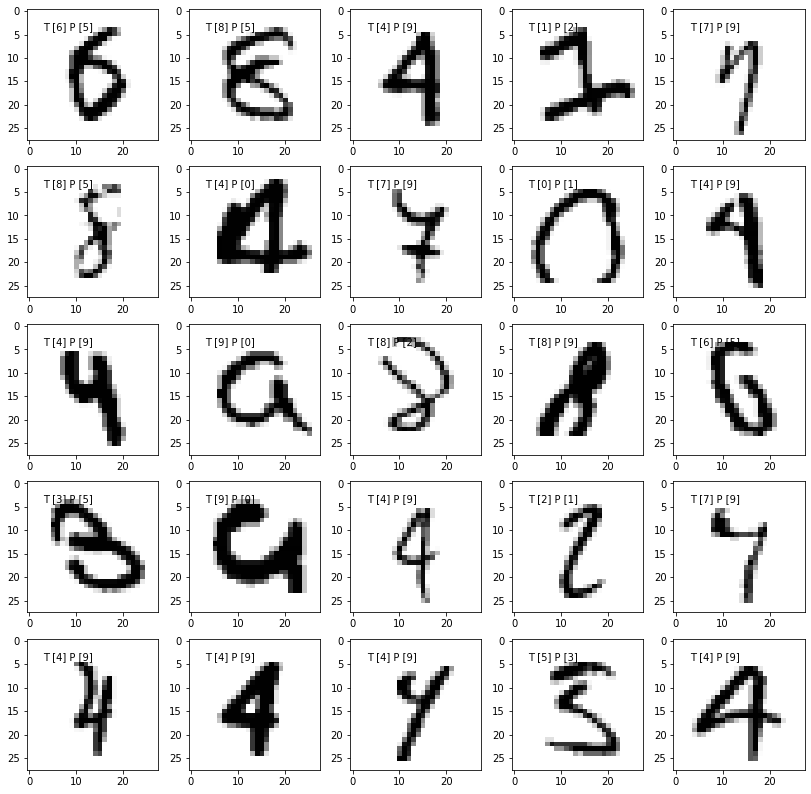

In [36]:
fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(5):
  for j in range(5):
    data,t,p = misclassified[index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    #axs[i,j].set_title(str(t.cpu().numpy())+" "+str(p.cpu().numpy()))
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;


In [28]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,"L2")
    # scheduler.step()
    test(model, device, test_loader,"L2")
test_loss_l2 = copy.deepcopy(test_losses)
test_acc_l2 = copy.deepcopy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.18199960887432098 Batch_id=468 Accuracy=87.63: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0972, Accuracy: 9732/10000 (97.32%)

EPOCH: 1


Loss=0.11959534138441086 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.12336623668670654 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.08733470737934113 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.0729699358344078 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.11505815386772156 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.06369908154010773 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.02867995575070381 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.05669332668185234 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.04008276388049126 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.11041667312383652 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.012972953729331493 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 38.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.05266829580068588 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.04542430117726326 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.03004024364054203 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.08074362576007843 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9914/10000 (99.14%)

EPOCH: 16


Loss=0.026824796572327614 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.06817586719989777 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 18


Loss=0.010268714278936386 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.027502961456775665 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 38.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.058716800063848495 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.05964408814907074 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.026514621451497078 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.016887202858924866 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.06199435144662857 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Loss=0.047540333122015 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 26


Loss=0.008382052183151245 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9950/10000 (99.50%)

EPOCH: 27


Loss=0.01744566485285759 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.04652521759271622 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

EPOCH: 29


Loss=0.019184179604053497 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 30


Loss=0.09323117882013321 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 31


Loss=0.007271813694387674 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Loss=0.018265672028064728 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 33


Loss=0.012267050333321095 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.055869948118925095 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.009111279621720314 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.02511114999651909 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 37


Loss=0.04485706984996796 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.01841464824974537 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 39


Loss=0.008441701531410217 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]



Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)



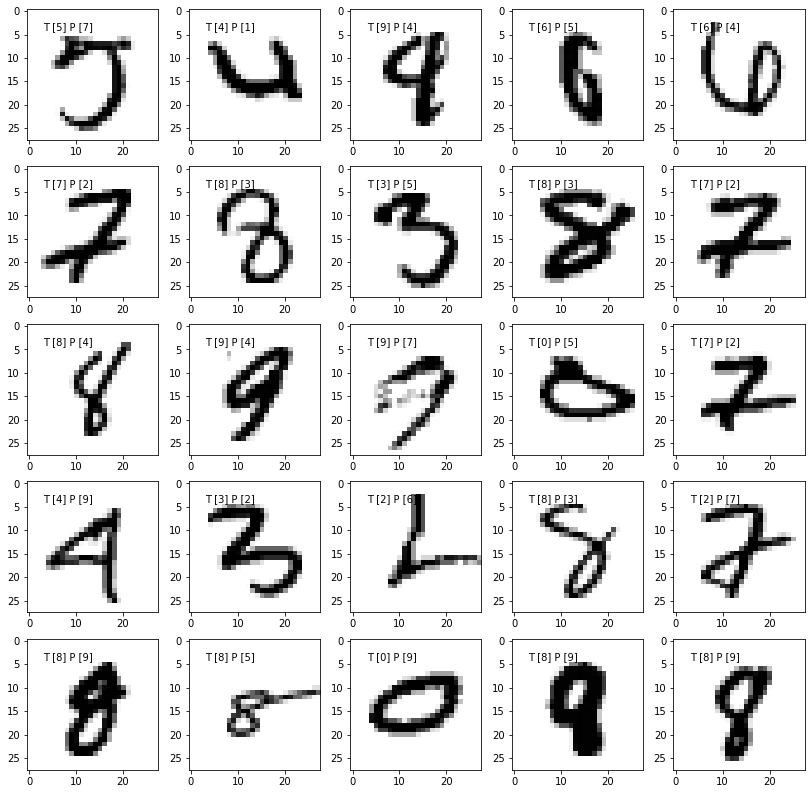

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(5):
  for j in range(5):
    data,t,p = misclassified[index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    #axs[i,j].set_title(str(t.cpu().numpy())+" "+str(p.cpu().numpy()))
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;


In [32]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,"Both")
    # scheduler.step()
    test(model, device, test_loader,"Both")
test_loss_both = copy.deepcopy(test_losses)
test_acc_both = copy.deepcopy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.17549197375774384 Batch_id=468 Accuracy=86.78: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1167, Accuracy: 9670/10000 (96.70%)

EPOCH: 1


Loss=0.19542109966278076 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.15012848377227783 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.13534660637378693 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.15621104836463928 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.14150629937648773 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.15595073997974396 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.10714356601238251 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9853/10000 (98.53%)

EPOCH: 8


Loss=0.14223946630954742 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.12809577584266663 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9897/10000 (98.97%)

EPOCH: 10


Loss=0.12560829520225525 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.11683525145053864 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.20153766870498657 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9866/10000 (98.66%)

EPOCH: 13


Loss=0.16949225962162018 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9884/10000 (98.84%)

EPOCH: 14


Loss=0.10570759326219559 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.12905128300189972 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9887/10000 (98.87%)

EPOCH: 16


Loss=0.10606275498867035 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9907/10000 (99.07%)

EPOCH: 17


Loss=0.1950330287218094 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)

EPOCH: 18


Loss=0.14884622395038605 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9902/10000 (99.02%)

EPOCH: 19


Loss=0.09234555810689926 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9904/10000 (99.04%)

EPOCH: 20


Loss=0.08979514241218567 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99.13%)

EPOCH: 21


Loss=0.1323201060295105 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 22


Loss=0.1001116931438446 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9910/10000 (99.10%)

EPOCH: 23


Loss=0.09742941707372665 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9911/10000 (99.11%)

EPOCH: 24


Loss=0.14702939987182617 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9907/10000 (99.07%)

EPOCH: 25


Loss=0.14324605464935303 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 26


Loss=0.17784756422042847 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9928/10000 (99.28%)

EPOCH: 27


Loss=0.13337282836437225 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 28


Loss=0.10736998915672302 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9910/10000 (99.10%)

EPOCH: 29


Loss=0.1573510318994522 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9904/10000 (99.04%)

EPOCH: 30


Loss=0.1004628837108612 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9889/10000 (98.89%)

EPOCH: 31


Loss=0.09278962016105652 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9911/10000 (99.11%)

EPOCH: 32


Loss=0.11958668380975723 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9906/10000 (99.06%)

EPOCH: 33


Loss=0.13551978766918182 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99.07%)

EPOCH: 34


Loss=0.12262611091136932 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

EPOCH: 35


Loss=0.10292030870914459 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 36


Loss=0.09711716324090958 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9888/10000 (98.88%)

EPOCH: 37


Loss=0.1158592700958252 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

EPOCH: 38


Loss=0.10741964727640152 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9920/10000 (99.20%)

EPOCH: 39


Loss=0.11862774193286896 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]



Test set: Average loss: 0.0337, Accuracy: 9895/10000 (98.95%)



Text(0.5, 1.0, 'Test Accuracy')

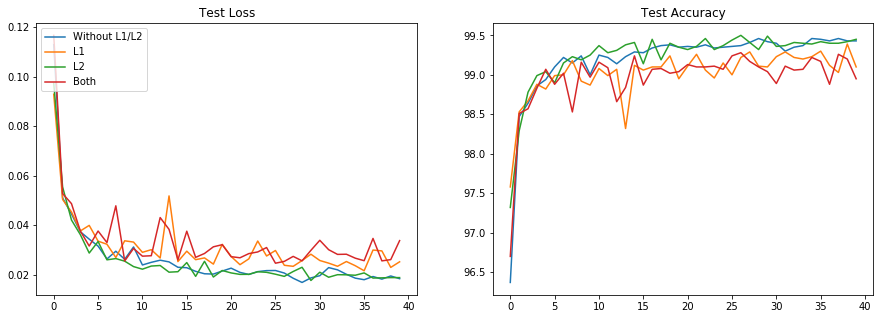

In [33]:
import matplotlib.pyplot as plt
# test_loss_l1=[]
# test_acc_l1=[]
# test_loss_l2=[]
# test_acc_l2=[]
# test_loss_both=[]
# test_acc_both=[]
# test_loss_none=[]
# test_acc_none=[]
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_loss_none)
axs[0].plot(test_loss_l1)
axs[0].plot(test_loss_l2)
axs[0].plot(test_loss_both)
axs[0].legend(['Without L1/L2', 'L1', 'L2', 'Both'], loc='upper left')
axs[0].set_title("Test Loss")
axs[1].plot(test_acc_none)
axs[1].plot(test_acc_l1)
axs[1].plot(test_acc_l2)
axs[1].plot(test_acc_both)
axs[0].legend(['Without L1/L2', 'L1', 'L2', 'Both'], loc='upper left')
axs[1].set_title("Test Accuracy")